Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

# Sentiment Analysis on IMDB Movie Review dataset

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


You will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

You can use this blog for understanding: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [2]:
%tensorflow_version 1.x
import tensorflow
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, Reshape
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import requests
from io import StringIO 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd 'drive/My Drive/PA6'

/content/drive/My Drive/PA6


All the relevant libraries are imported. 
You are free to change as you please. 
Using the GPU backend is recommended as LSTMs are computationally expensive to train.



## Data handling - exploration and cleaning





1.   You are expected to read the dataset into a dataframe.
2.   This is a real world dataset and you will be expected to clean the dataset.

1.   This includes removing trailing spaces and HTML tags.






In [0]:
df = pd.read_csv('IMDB Dataset.csv')

In [6]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [7]:
df.head(10)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

### Data Cleaning - write the techniques you employed and the achieved results

In [0]:
def clean(df):
  # removing html tags
  df = df.str.replace('<.*?>',' ')

  # removing numbers
  df = df.str.replace(r'[0-9]'," ")

  # converting to lower case
  df = df.str.lower()

  # removing punctuation         
  df = df.str.replace(r'[!"#$%&()*+,-./:;<=>?@\[\]^_`{"}~\t\n]'," ")
  df = df.str.replace(r" '"," ")
  df = df.str.replace(r"' "," ")
  df = df.str.replace(r"\b'\b"," ")
  df = df.str.replace(r'\s{2,}'," ")

  # eliminate stop words
  stop = stopwords.words('english')
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  df = df.str.replace(pat,' ')

  # removing any random single letters
  df = df.str.replace(r' [a-zA-Z] '," ")

  # eliminate extra whitespace
  df = df.str.strip()
  df = df.str.replace(r'\s{2,}'," ")

  return df


In [97]:
df['review'] = clean(df['review'])
df.head(10)

,review,sentiment
0,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewing thats get touch darker side,positive
1,wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done,positive
2,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends,positive
3,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots well playing parents descent dialogs shots jake ignore,negative
4,petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power success people different situations encounter variation arthur schnitzler play theme director transfers action present time new york different characters meet connect one connected one way another next person one seems know previous point contact stylishly film sophisticated luxurious look taken see people live world live habitat thing one gets souls picture different stages loneliness one inhabits big city exactly best place human relations find sincere fulfillment one discerns case people encounter acting good mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast make characters come alive wish mr mattei good luck await anxiously next work,positive
5,probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slo

Write about the techniques used to clean:

Multiple regular expressions and dataframe.series.str functions were used to clean the data including:


*   Removing any html tags
*   removing numbers
*   converting all text to lower case
*   removing punctuation except the character ' when it is in the middle of letters such as they're or you're
*  eliminating stopwords using the nltk list of stopwords
*  eliminating extra spaces between words and at the end/beginning of sentences

The order mentioned above is how the text was cleaned. punctuation was removed and the text converted to lower case before removing stopwords. so that all stopwords are recognizable and removed.

Similarly all extra white space is eliminated at the end as the earlier operations make extra white space on their own.

### Data Exploration



1.   You are required to report the total number of distinct tokens present in the data set.
2.   Find out the minimum and max length of a review.

An integral part of visualization when it comes to textual data is the generating of a word cloud.

1.   
This task is open-ended and you can use any library of your choice. 
NLTK is one such library. 
2.   
Make sure to keep note of stop words.

##Example:


![alt text](https://getthematic.com/wp-content/uploads/2018/03/Harris-Word-Cloud-e1522406279125.png)




In [98]:
# distinct tokens
tokens = [x.split(' ') for x in df['review']]
flatten_list = [j for sub in tokens for j in sub] 
distinct_size =len(set(flatten_list))
print('total number of distinct tokens is %d'%distinct_size)

# min and max length of reviews
minimum = df['review'].str.len().min()
maximum = df['review'].str.len().max()
print('maximum length: %d' % maximum)
print('minimum lenght: %d' % minimum)

total number of distinct tokens is 100644
maximum length: 9126
minimum lenght: 17


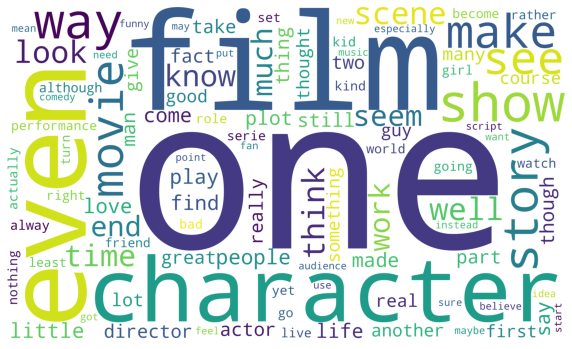

In [21]:
# word cloud - already eliminated stop words while cleaning
str_token = " ".join(flatten_list)
wordcloud = WordCloud(width = 5000, height = 3000, 
                background_color ='white',
                max_words = 100).generate(str_token)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

### Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

### Tokenizer
You will need to use fit a tokenizer over your training and testing data.

What does a tokenizer do?
It creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts. You should read up on the documentation before diving into the code. 

You will also be using the the text_to_sequence function will return integers based on a respective tokenizer.

Make sure you **pad** your sequences to max length using sequence.pad_sequences()




In [0]:
shorten = 3000
df['review'] = [x[:shorten] for x in df['review']]

In [0]:
# seperating train and test
df['sentiment'] = df['sentiment'].replace('positive',1)
df['sentiment'] = df['sentiment'].replace('negative',0)
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size = 0.3, shuffle = True)

In [0]:
# fitting the tokenizer and creating sequences
distinct_size = distinct_size
tokenizer = Tokenizer(num_words = distinct_size)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [0]:
# padding sequences
x_train_seq = pad_sequences(x_train_seq, shorten)
x_test_seq = pad_sequences(x_test_seq, shorten)

### Embedding layer
You will be importing the embedding layer from Keras.
Embedding layers are common place when handling textual data. 
Word embeddings provide a dense representation of words and their relative meanings.

#### How do they work - via Stack Overflow
Link: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

The output vectors are not computed from the input using any mathematical operation. Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

Hope to see you soon

Nice to see you again

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argumet, of course, determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors.


### Model Engineering

You will be required to engineer three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs

1.   A model with less than 10,000 parameters - the lower the parameters, higher the score (provided accuracy is good)


For each model:

1.   You will be reporting graphs for validation accuracy and training loss.
2.   What hyper-parameters, loss functions, optimizations, initializations were used. This should be clearly stated in your analysis.

~90 percent and above is the desired accuracy. 

For model 3, CLEARLY report the number of parameters.




# LSTM

In [0]:
BATCH_SIZE = 512

def plot_accuracy(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
# LSTM model
input_dim = distinct_size        # kept at 100644
output_dim = 3                   # kept at 3
input_len = x_train_seq.shape[1] # kept at 3000

model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=input_len))
model.add(LSTM(200))
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(0.0005),
              metrics=['accuracy'])

In [0]:
model_name = 'lstm_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
checkpoint1 = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_accuracy:.2f}.h5', 
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
cvslogger1 = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

callbacks1 = [checkpoint1, cvslogger1, reducelr1]

In [44]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3000, 3)           301932    
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               163200    
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              205824    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 671,981
Trainable params: 671,981
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(x_train_seq,y_train,
          epochs=15,
          callbacks = callbacks1,
          validation_data = (x_test_seq,y_test),
          batch_size = BATCH_SIZE,
          use_multiprocessing = True, workers = 50)

Train on 35000 samples, validate on 15000 samples
Epoch 1/15
35000/35000 [==============================] - 382s 11ms/step - loss: 0.6868 - accuracy: 0.5496 - val_loss: 0.6554 - val_accuracy: 0.7098

Epoch 00001: val_accuracy improved from -inf to 0.70980, saving model to lstm_model/lstm_model-01-0.71.h5
Epoch 2/15
35000/35000 [==============================] - 376s 11ms/step - loss: 0.5328 - accuracy: 0.7645 - val_loss: 0.3878 - val_accuracy: 0.8238

Epoch 00002: val_accuracy improved from 0.70980 to 0.82380, saving model to lstm_model/lstm_model-02-0.82.h5
Epoch 3/15
35000/35000 [==============================] - 376s 11ms/step - loss: 0.2714 - accuracy: 0.8913 - val_loss: 0.2902 - val_accuracy: 0.8829

Epoch 00003: val_accuracy improved from 0.82380 to 0.88293, saving model to lstm_model/lstm_model-03-0.88.h5
Epoch 4/15
35000/35000 [==============================] - 377s 11ms/step - loss: 0.1736 - accuracy: 0.9365 - val_loss: 0.2819 - val_accuracy: 0.8895

Epoch 00004: val_accuracy 

In [0]:
# Analysis
lstm = load_model('lstm_model/lstm_model-10-0.89.h5')
lstm_hist = pd.read_csv('lstm_model/logs.csv')

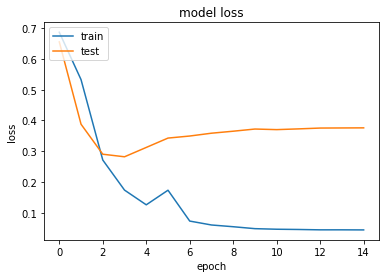

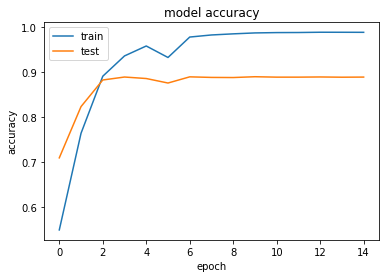

In [56]:
plot_loss(lstm_hist)
plot_accuracy(lstm_hist)

**Optimizer** = Adam with lr = 0.0005

**Activation function** = Sigmoid

**Loss function** = Binary Crossentropy

**Callbacks** = ModelCheckpoint (saves best validation acc), cvslogger and ReduceLROnPlateau

**parems**: 671981 (as shown above in model summary)

no special initialization was used. Furthermore test data was used as validation data and so the validation accuracy is test accuracy

**Max accuracy achieved**: 0.89

**plot analysis**: the training loss decreases over epochs and while validation loss increases suddenly that may be a sign of overfitting, however valdation accuracy does not have a sudden decrease. Showing that it is not overfitting.

Otherwise the plots indicate that th training went smoothly.




# Bi-LSTM

In [15]:
# Bi LSTM
input_dim = distinct_size  #kept at 100644
output_dim = 5             #kept at 5
input_len = x_train_seq.shape[1]  # kept at 3000
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.
model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=input_len))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(0.0005),
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model_name = 'Bi-lstm_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
checkpoint1 = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_accuracy:.2f}.h5', 
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
cvslogger1 = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

callbacks1 = [checkpoint1, cvslogger1, reducelr1]

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3000, 5)           503220    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               329600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 833,221
Trainable params: 833,221
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_train_seq,y_train,
          epochs=15,
          callbacks = callbacks1,
          validation_data = (x_test_seq,y_test),
          batch_size = 400,
          use_multiprocessing = True, workers = 100)


Train on 35000 samples, validate on 15000 samples
Epoch 1/15
35000/35000 [==============================] - 835s 24ms/step - loss: 0.6965 - accuracy: 0.5951 - val_loss: 0.6803 - val_accuracy: 0.7033

Epoch 00001: val_accuracy improved from -inf to 0.70327, saving model to Bi-lstm_model/Bi-lstm_model-01-0.70.h5
Epoch 2/15
35000/35000 [==============================] - 836s 24ms/step - loss: 0.6038 - accuracy: 0.7675 - val_loss: 0.4070 - val_accuracy: 0.8385

Epoch 00002: val_accuracy improved from 0.70327 to 0.83853, saving model to Bi-lstm_model/Bi-lstm_model-02-0.84.h5
Epoch 3/15
35000/35000 [==============================] - 832s 24ms/step - loss: 0.4855 - accuracy: 0.7973 - val_loss: 0.3789 - val_accuracy: 0.8336

Epoch 00003: val_accuracy did not improve from 0.83853
Epoch 4/15
35000/35000 [==============================] - 829s 24ms/step - loss: 0.3170 - accuracy: 0.8775 - val_loss: 0.3653 - val_accuracy: 0.8366

Epoch 00004: val_accuracy did not improve from 0.83853
Epoch 5/15
3

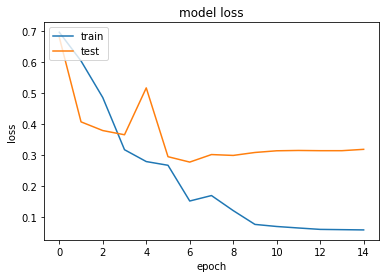

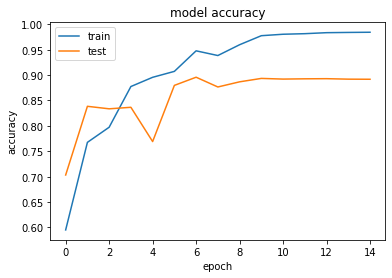

In [12]:
# Analysis
bi_lstm = load_model('Bi-lstm_model/Bi-lstm_model-07-0.90.h5')
bi_lstm_hist = pd.read_csv('Bi-lstm_model/logs.csv')
plot_loss(bi_lstm_hist)
plot_accuracy(bi_lstm_hist)

**Optimizer** = Adam with lr = 0.0005

**Activation function** = Sigmoid

**Loss function** = Binary Crossentropy

**Callbacks** = ModelCheckpoint (saves best validation acc), cvslogger and ReduceLROnPlateau

**parems**: 833221 (as shown above in model summary)

no special initialization was used. Furthermore test data was used as validation data and so the validation accuracy is test accuracy

**Max accuracy achieved**: 0.90

**plot analysis**: Training went smoohly up until the 3rd epoch when while training loss decreased, validation loss increased and while training acc increased, validation acc decreased. So for a while the model overfit. However it recovered after the 4th epoch as shown from the plot. that the loss started decreasing again and accuracy started increasing again.


# 10 000 parem model

In [0]:
# parem model
input_dim = distinct_size  #kept at 1500
output_dim = 2             #kept at 2
input_len = x_train_seq.shape[1] # kept at 1000

model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=input_len))
model.add(LSTM(25))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(0.0005),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 2)           3000      
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                2800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 5,826
Trainable params: 5,826
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = 'parem_model1'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
checkpoint1 = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_accuracy:.2f}.h5', 
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
cvslogger1 = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

callbacks1 = [checkpoint1, cvslogger1, reducelr1]

In [46]:
model.fit(x_train_seq,y_train,
          epochs=15,
          callbacks = callbacks1,
          validation_data = (x_test_seq,y_test),
          batch_size = 512,
          use_multiprocessing = True, workers = 100)

Train on 35000 samples, validate on 15000 samples
Epoch 1/15
35000/35000 [==============================] - 85s 2ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6926 - val_accuracy: 0.5397

Epoch 00001: val_accuracy improved from -inf to 0.53973, saving model to parem_model1/parem_model1-01-0.54.h5
Epoch 2/15
35000/35000 [==============================] - 86s 2ms/step - loss: 0.6794 - accuracy: 0.5709 - val_loss: 0.6396 - val_accuracy: 0.6825

Epoch 00002: val_accuracy improved from 0.53973 to 0.68247, saving model to parem_model1/parem_model1-02-0.68.h5
Epoch 3/15
35000/35000 [==============================] - 86s 2ms/step - loss: 0.5771 - accuracy: 0.7282 - val_loss: 0.4872 - val_accuracy: 0.7770

Epoch 00003: val_accuracy improved from 0.68247 to 0.77700, saving model to parem_model1/parem_model1-03-0.78.h5
Epoch 4/15
35000/35000 [==============================] - 84s 2ms/step - loss: 0.6014 - accuracy: 0.7604 - val_loss: 0.5005 - val_accuracy: 0.8097

Epoch 00004: val_accur

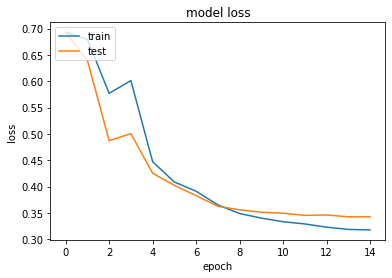

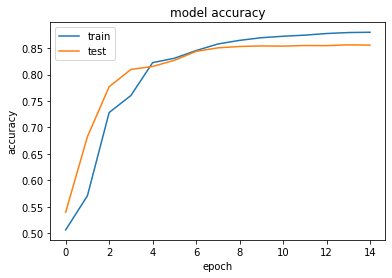

In [58]:
# Analysis
parem = load_model('parem_model1/parem_model1-14-0.86.h5')
parem_hist = pd.read_csv('parem_model1/logs.csv')
plot_loss(parem_hist)
plot_accuracy(parem_hist)

**Optimizer** = Adam with lr = 0.0005

**Activation function** = Sigmoid

**Loss function** = Binary Crossentropy

**Callbacks** = ModelCheckpoint (saves best validation acc), cvslogger and ReduceLROnPlateau

**parems**: 5826 (as shown above in model summary)

no special initialization was used. Furthermore test data was used as validation data and so the validation accuracy is test accuracy

**Max accuracy achieved**: 0.86

**plot analysis**: Training went smoothly. loss decreased over epochs and accuracy increased over epochs

### Model Predictions. For your best performing model

Come up with ten sample sentences NOT part of the original data set. 
Use model.predict() to generate predictions and report positive or negative sentiment.

In [0]:
sentences = ["well that movie went better than expected. From the reviews one would think it would be adequete;. But surprisingly, Bobby Robbins pulls through as a great film. The scenes and visual effects were amazing. the director was through with this one",
             "Talk about a waste of money. Who could've predicted that the famous louis' feature picture could be so boring. The characters were cliche'd and overused. The actors themselved looked tired of having to play the parts. Didn't like it at all. 1/10",
             "This was phenomenal. Never have I ever seen a better performance. 10/10",
             "While the first half of the film made no sense, I was surprised by the sudden character development and new introductions made. It somehow made it work. I feel it used the same idea as game of thrones; to show the story from a different point of view and make them intersect. Not original but well executed.",
             "How do I say this....It was terrible. There.",
             "another great film by Testy Harness. Will very likely go to see again.",
             "ridiculous, uninspiring and a shame to its name. It will forever be remembered as a travesty to the scottish name. What a waste of money. I hope I never have to see this again.",
             "David choqosky has finally cleaned up his act and put together a decent film. This one could be oscar-worthy, it is not the boring cliche's he was bringing to the table for the past 2 years. Good reviews.",
             "I'm dissapointed. penelople was to be one of the major releases this year, but it has been pathetic to say the least. An escaped convict hides on a farm and seduces your local farmer. what a joke!",
             "I have no words for how bad this was....truly my cat edmund could've done a better job with the sound effects. You'd think you were watching a parody made for a school project. yikes!!!"]

sentiments = [1,0,1,1,0,1,0,1,0,0]

In [82]:
test_df = pd.DataFrame(sentences, columns=['review'])
test_df['review'] = clean(test_df['review'])
test_df

,review
0,well movie went better expected reviews one would think would adequete surprisingly bobby robbins pulls great film scenes visual effects amazing director one
1,talk waste money could predicted famous louis feature picture could boring characters cliche overused actors themselved looked tired play parts like
2,phenomenal never ever seen better performance
3,first half film made sense surprised sudden character development new introductions made somehow made work feel used idea game thrones show story different point view make intersect original well executed
4,say terrible
5,another great film testy harness likely go see
6,ridiculous uninspiring shame name forever remembered travesty scottish name waste money hope never see
7,david choqosky finally cleaned act put together decent film one could oscar worthy boring cliche bringing table past years good reviews
8,dissapointed penelople one major releases year pathetic say least escaped convict hides farm seduces local farmer joke
9,words bad truly cat edmund could done better job sound effects think watching parody made school project yikes


In [0]:
test_seq = tokenizer.texts_to_sequences(test_df['review'])
final_seq = pad_sequences(test_seq,3000)

In [0]:
bi_lstm = load_model('Bi-lstm_model/Bi-lstm_model-07-0.90.h5')

In [0]:
ans = bi_lstm.predict(final_seq)
ans = np.round(ans)
ans = ans.reshape((10,))

In [86]:
print(ans)          # predicted
print(sentiments)   # actual

[1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
[1, 0, 1, 1, 0, 1, 0, 1, 0, 0]


In [94]:
diff = ans - sentiments
ab = np.absolute(diff)
accuracy = ((10 - np.sum(ab))/10) * 100

print('accuracy = %.2f'% accuracy, end = '%')

accuracy = 90.00%

So while the model predicted the correct sentiment for 9/10 sentences.
The one it predicted wrong is:

"This was phenomenal. Never have I ever seen a better performance. 10/10"

While this was one of the more 'extreme' positive sentences, the model predictd it as negative.
Perhaps it was because it was too short and had both 'never' and 'better performance' which confused the model about it was actually trying to say.